In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Data Cleaning

In [2]:
from unidecode import unidecode
import os, json
import datetime
def format_date(date):
    day, month, year = date.split("-")
    return datetime.datetime(int(year), int(month), int(day)).strftime("%Y-%m-%d")
                                  
def speeches_from_json(json_file):
    with open(json_file, "r") as f:
        data = json.load(f)
    return [{
        #"report_id": json_file.split("\\")[-1], 
        "section": data["section"], 
        "date": format_date(data["date"]),
        "topic": data["title"],
        "name": unidecode(speech["name"] or ''),
        "speech": unidecode(speech["speech"] or ''),
    } for speech in data["speeches"]]

First, load all json files

In [3]:
DIR = ".\\parliament"

In [4]:
speeches = [speech for parliament_number in os.listdir(DIR) if not parliament_number.endswith(".txt")
                   for f in os.listdir(f"{DIR}\\{parliament_number}") if f.lower().endswith(".json") 
                   for speech in speeches_from_json(f"{DIR}\\{parliament_number}\\{f}")]

Create a data frame

In [5]:
df = pd.DataFrame.from_records(speeches)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203062 entries, 0 to 203061
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   section  203062 non-null  object
 1   date     203062 non-null  object
 2   topic    203062 non-null  object
 3   name     203062 non-null  object
 4   speech   203062 non-null  object
dtypes: object(5)
memory usage: 7.7+ MB


In [6]:
df.head()

,section,date,topic,name,speech
0,BILLS,1965-12-13,CONSTITUTION (AMENDMENT) BILL,CONSTITUTION (AMENDMENT) BILL,
1,BILLS,1965-12-13,CONSTITUTION (AMENDMENT) BILL,First Reading,
2,BILLS,1965-12-13,CONSTITUTION (AMENDMENT) BILL,The Prime Minister:,"Mr Speaker, Sir, I have His Excellency the Yan..."
3,BILLS,1965-12-13,CONSTITUTION (AMENDMENT) BILL,Second Reading,
4,BILLS,1965-12-13,CONSTITUTION (AMENDMENT) BILL,Mr Speaker:,"Second Reading, what day?"


Drop rows with empty names and speeches

In [7]:
df = df.dropna()

### Convert 'date' from string to datetime

In [8]:
df['date'] = pd.to_datetime(df['date'])

### Normalize case

In [9]:
def normalize_case(text):
    return text.lower()

In [10]:
df['section'] = df['section'].map(normalize_case)
df['topic'] = df['topic'].map(normalize_case)
df['name'] = df['name'].map(normalize_case)
df['speech'] = df['speech'].map(normalize_case)

In [11]:
#df['topic'] = df['topic'].map(lambda text: re.sub(r"[^a-z. ]", "", text))
df['name'] = df['name'].map(lambda text: re.sub(r"[^a-z. ]", "", text))
#df['speech'] = df['speech'].map(remove_punctuations)

In [12]:
df.head()

,section,date,topic,name,speech
0,bills,1965-12-13,constitution (amendment) bill,constitution amendment bill,
1,bills,1965-12-13,constitution (amendment) bill,first reading,
2,bills,1965-12-13,constitution (amendment) bill,the prime minister,"mr speaker, sir, i have his excellency the yan..."
3,bills,1965-12-13,constitution (amendment) bill,second reading,
4,bills,1965-12-13,constitution (amendment) bill,mr speaker,"second reading, what day?"


# 13th Parliament

In [13]:
df = df[(df['date'] >= pd.Timestamp(2016, 1, 15)) & (df['date'] <= pd.Timestamp(2020, 6, 23))]
df.shape

(21616, 5)

Remove punctations from names

In [14]:
df['name'] = df['name'].map(lambda text: re.sub(r"[^a-z. ]", "", text))

Delete rows with empty names and speeches

In [15]:
df = df[~(df['name'] == '')]
df = df[~(df['speech'] == '')]
df.shape

(21205, 5)

### Map MPs' names

How many MPs in the data frame?

In [16]:
df['name'].unique().shape

(624,)

How many actual MPs ?

In [17]:
with open(f"{DIR}\\mp.txt") as f:
    MP = np.array([re.sub(r"[^a-z. ]", "", line.replace("\n","").lower().strip()) for line in f.readlines() if line.strip()])
    print("Number of actual MPs:", len(MP))

Number of actual MPs: 524


The number of MPs in the dataframe is greater than the actual number. Let's correct this.

Prime Ministers was sometimes referred to as "the prime minister" instead of their names. We have to replace these by their names:
* lee kuan yew: 1959-06-05 to 1990-11-28
* goh chok tong: 1990-11-28 to 2004-08-12
* lee hsien loong: 2004-08-12 to present

In [18]:
df.loc[(df['name'] == "the prime minister") & (df['date'] < pd.Timestamp(1990, 11, 28)), "name"] = 'lee kuan yew'
df.loc[(df['name'] == "the prime minister") & (df['date'] >= pd.Timestamp(1990, 11, 28)) & (df['date'] < pd.Timestamp(2004, 8, 12)), "name"] = 'goh chok tong'
df.loc[(df['name'] == "the prime minister") & (df['date'] >= pd.Timestamp(2004, 8, 12)), "name"] = 'lee hsien loong'

Map names to known MPs

In [19]:
def map_text_to_mp(text, mp):
    for name in mp:
        if name in text:
            return name
    return ""

In [20]:
df['name'] = df['name'].map(lambda text: map_text_to_mp(text, MP))

Remove rows with empty names again

In [21]:
df = df[~(df['name'] == '')]

Reset index

In [22]:
df = df.reset_index(drop=True)
df.shape

(17188, 5)

In [23]:
df.head()

,section,date,topic,name,speech
0,second reading bills,2018-05-18,vulnerable adults bill,desmond lee,": mr speaker, i beg to move, that the bill be ..."
1,second reading bills,2018-05-18,vulnerable adults bill,desmond lee,": thank you. sir, this bill seeks to protect i..."
2,second reading bills,2018-05-18,vulnerable adults bill,denise phua lay peng,": mr speaker, sir, i stand in full support of ..."
3,second reading bills,2018-05-18,vulnerable adults bill,sylvia lim,": mr speaker, sir, this bill seeks to give the..."
4,second reading bills,2018-05-18,vulnerable adults bill,chia yong yong,": thank you, sir, may i declare interest as pr..."


In [24]:
df['speech'] = df['speech'].map(lambda text: re.sub(r"^: ", "", text))

### Merge similar sections

How many types of sections?

In [25]:
df['section'].unique()

array(['second reading bills', 'bills introduced', 'budget',
       'clarification', 'matter raised on adjournment motion',
       'ministerial statements', 'motions', 'oral answers to questions',
       'personal explanation', 'petitions', "president's address",
       'speaker', 'tributes', 'written answers to questions',
       'written answers to questions for oral answer not answered by end of question time',
       'correction by written statement'], dtype=object)

Reduce the number of sections by merging similar ones

Merge all "..answer to question.." into "answers to questions"

In [26]:
df['section'] = df['section'].map(lambda c: 'answers to questions' if re.search(r"answer(s?) to question(s?)", c) else c)

Merge all "..motion.." into "motions"

In [27]:
df['section'] = df['section'].map(lambda c: 'motions' if re.search(r"motion(s?)", c) else c)

Merge "bills" and "second reading bills" into "bills"

In [28]:
df['section'] = df['section'].map(lambda c: 'bills' if re.search(r"bill(s?)", c) else c)

Convert it to categorical data

In [29]:
df["section"] = df["section"].astype("category")

Sort the dataframe by date

In [30]:
df = df.sort_values('date', ascending=False).reset_index(drop=True)
df.head()

,section,date,topic,name,speech
0,answers to questions,2020-06-05,consequences for and enforcement against emplo...,josephine teo,the vast majority of employers are now paying ...
1,budget,2020-06-05,second supplementary estimates of expenditure ...,anthea ong,"thank you, mr chairman. i thank the senior min..."
2,budget,2020-06-05,second supplementary estimates of expenditure ...,indranee rajah,"mr chairman, if i may now address ms ong's que..."
3,budget,2020-06-05,second supplementary estimates of expenditure ...,anthea ong,"mr chairman, i beg leave to withdraw the amend..."
4,budget,2020-06-05,second supplementary estimates of expenditure ...,anthea ong,"chairman, i beg to move, ""that the total sum t..."


Calculate length of speech in terms of characters and words

In [31]:
df['length'] = df['speech'].str.split().map(lambda x: len(x))

Export to csv

In [32]:
df.to_csv("parliament_13.csv")

# Text statistics

Calculate length of speech in terms of characters and words

In [189]:
stat_df = df.copy()
stat_df['length'] = stat_df['speech'].str.split().map(lambda x: len(x))
stat_df.head()

,section,date,topic,name,speech,length
0,answers to questions,2020-06-05,consequences for and enforcement against emplo...,josephine teo,the vast majority of employers are now paying ...,142
1,budget,2020-06-05,second supplementary estimates of expenditure ...,anthea ong,"thank you, mr chairman. i thank the senior min...",79
2,budget,2020-06-05,second supplementary estimates of expenditure ...,indranee rajah,"mr chairman, if i may now address ms ong's que...",261
3,budget,2020-06-05,second supplementary estimates of expenditure ...,anthea ong,"mr chairman, i beg leave to withdraw the amend...",36
4,budget,2020-06-05,second supplementary estimates of expenditure ...,anthea ong,"chairman, i beg to move, ""that the total sum t...",440


Speech length statistics

In [192]:
stat_df['length'].describe()

count    17188.000000
mean       463.295962
std        819.734738
min          1.000000
25%         90.000000
50%        192.000000
75%        413.000000
max      15354.000000
Name: length, dtype: float64

Distribution of speech length

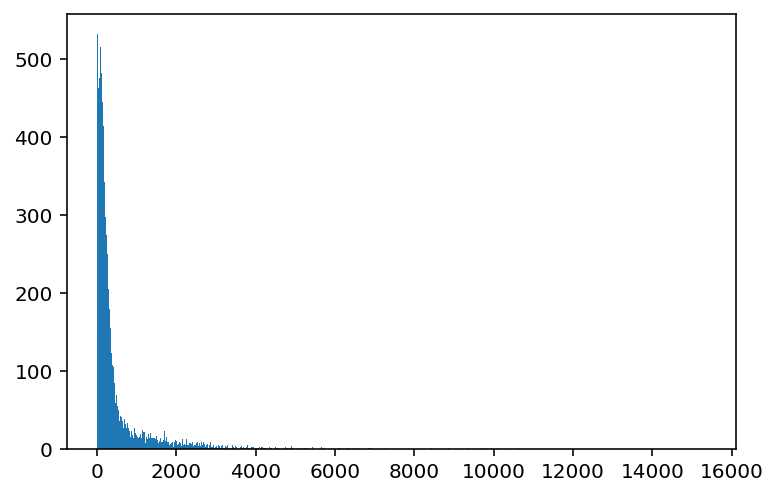

In [193]:
bins = np.arange(0, stat_df['length'].max(), 10)
plt.hist(stat_df['length'], bins=bins)
plt.show()

This resembles powerlaw distribution. Let's verify that

Calculating best minimal value for power law fit


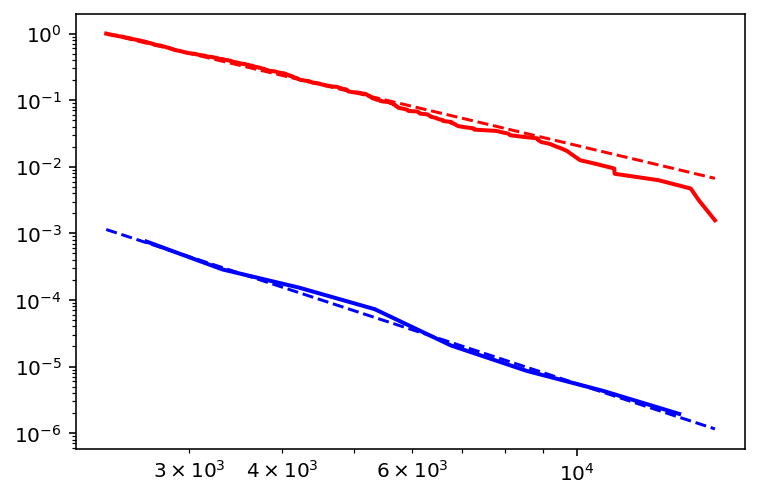

In [194]:
import powerlaw
fit = powerlaw.Fit(stat_df['length'], discrete=True)
fig = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig)
fit.plot_ccdf(color='r', linewidth=2, ax=fig)
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=fig)
plt.show()

Who spoke the most?

In [195]:
stat_df.groupby(["name"])["length"].agg(['count', 'mean']).sort_values(by=["count", "mean"], ascending=False)

,count,mean
name,,
lawrence wong,821,287.479903
k shanmugam,638,465.650470
khaw boon wan,608,196.041118
josephine teo,536,461.360075
gan kim yong,527,327.857685
...,...,...
david ong,4,559.000000
goh chok tong,2,815.500000
halimah yacob,1,3152.000000


In [ ]:
parliament14_df = df[df['date'] >= '2020-08-24']
parliament14_df